In [1]:
%pylab inline 
import numpy as np
import cv2
from sklearn.utils import shuffle
from scipy.misc import imresize
import pandas as pd
import os

from keras.models import Model
from keras.layers import Cropping2D, Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Lambda, concatenate, Activation
from keras import initializers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
data_path = 'data/'

#log = pd.read_csv(data_path + 'driving_log.csv')

In [3]:
logs = []

headers = 'center,left,right,steering,throttle,brake,speed'.split(',')
for name in os.listdir(data_path):
    path = data_path+ name + '/driving_log.csv'
    print('reading ', path)
    log = pd.read_csv(path, names=headers)
    logs.append([data_path+name,log])

reading  data/mw/driving_log.csv
reading  data/data/driving_log.csv
reading  data/mw_2/driving_log.csv
reading  data/mw_2_oterway/driving_log.csv
reading  data/mw2_simple/driving_log.csv
reading  data/mw2_simple_otherway/driving_log.csv


In [ ]:
logs[5][1].tail()

In [ ]:
log = pd.concat(g[1] for g in logs)

In [5]:
for g in logs:
    print(len(g[1]))
    print(g[1]['center'][0], g[0])
print("---", len(log))

18230
C:\Users\viacheslav.maslov\study\udacity\SDND\BehavioralCloning\imgs\IMG\center_2017_07_26_21_51_25_834.jpg data/mw
8036
IMG/center_2016_12_01_13_30_48_287.jpg data/data
5687
c:\Users\viacheslav.maslov\study\udacity\Behavioral-Cloning\mw_2\IMG\center_2017_08_06_20_21_36_892.jpg data/mw_2
3654
C:\Users\viacheslav.maslov\study\udacity\Behavioral-Cloning\mw_2_oterway\IMG\center_2017_08_06_20_36_14_093.jpg data/mw_2_oterway
3605
C:\Users\viacheslav.maslov\study\udacity\Behavioral-Cloning\mw2_simple\IMG\center_2017_08_06_20_45_00_411.jpg data/mw2_simple
4387
C:\Users\viacheslav.maslov\study\udacity\Behavioral-Cloning\mw2_simple_otherway\IMG\center_2017_08_06_20_54_06_744.jpg data/mw2_simple_otherway
--- 4387


In [ ]:
# log[log['steering']==0].head()
ipath = log.iloc[0]['center']
print(ipath)
print('/'.join(ipath.split('\\')[-2:]))

In [6]:
def readAndAppend(path, images, steerings, en, camera, offset=0, path_level=2):
    ipath = en[camera].strip()
    ipath = '/'.join(ipath.split('\\')[-(path_level):])
    path = path + ipath
    #print(path)
    image = cv2.imread(path)
    if image is None:
        print('cant open an image', path)
        return False
    im_shape = [int(x/2) for x in image.shape[:2]]
    #image = imresize(image, (im_shape))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)
    steering = float(en['steering'])
    if abs(steering) < (1 - abs(offset)):
        steering += offset
    steerings.append(steering)  
    return True
    
readAndAppend(data_path, [], [], log.iloc[0], 'center', 0)

cant open an image data/IMG/center_2017_08_06_20_54_06_744.jpg


False

In [12]:
images = []
steerings = []

def readAllImgs(logs, path, path_level=2):
    #for i,en in log[log['steering']!=0].iterrows():
    err = 0    
    for folder, log in logs:
        print(folder)
        for i,en in log.iterrows():
            #path = path + folder + '/'
            ret = readAndAppend(folder + '/', images, steerings, en, 'center', 0)
            if not ret:
                err += 1
            #readAndAppend(data_path, images, steerings, en, 'left', 0.15)
            #readAndAppend(data_path, images, steerings, en, 'right', -0.15)
    print(err)
readAllImgs(logs, data_path)


data/mw
data/data
data/mw_2
data/mw_2_oterway
data/mw2_simple
data/mw2_simple_otherway
0


In [13]:
len(images)

43599

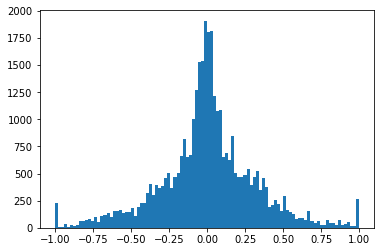

In [28]:
pyplot.hist([x for x in steerings if abs(x) > 0.], bins=100)
plt.show()

In [44]:
# whole data
X_data = np.array(images)
y_data = np.array(steerings)

k = 0.3
# far from zero: for augmenting
X_data_nz = np.array([x for i,x in enumerate(images) if abs(steerings[i]) > k])
y_data_nz = np.array([y for y in steerings if abs(y) > k])

# close to zero
X_data_z = np.array([x for x,y in zip(images, steerings) if abs(y) <= k and y!=0])
y_data_z = np.array([y for y in steerings if abs(y) <= k and y!=0])


In [45]:
print(X_data.shape)
print(X_data_nz.shape)
print(X_data_z.shape)

(43599, 160, 320)
(10302, 160, 320)
(25427, 160, 320)


In [31]:
pic_num = 0

-0.1503759
(43599, 160, 320)
(10302, 160, 320)
1


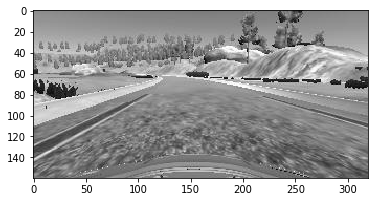

In [46]:
pic_num += 1
imshow(X_data[pic_num], cmap='gray')
print(y_data[pic_num])
print(X_data.shape)
print(X_data_nz.shape)
print(pic_num)

In [33]:
from keras.preprocessing.image import ImageDataGenerator

In [51]:
# set up image data generator first
X_gen = np.empty((0, *X_data_nz[0].shape, 1))
y_gen = np.zeros((0,))


In [ ]:
X_data = None

In [52]:
print(XG_train.shape, YG_train.shape)
print(X_gen.shape, y_gen.shape)

(30204, 160, 320, 1) (30204,)
(0, 160, 320, 1) (0,)


In [53]:
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator = train_datagen.flow(X_data_nz.reshape((*X_data_nz.shape, 1)), y_data_nz, batch_size=250)
for i,im in zip(range(100), train_generator):
    X_gen = np.append(X_gen, im[0].astype(np.ubyte), axis=0)
    y = im[1] * (-1) 
    y_gen= np.append(y_gen, y, axis=0)

24604


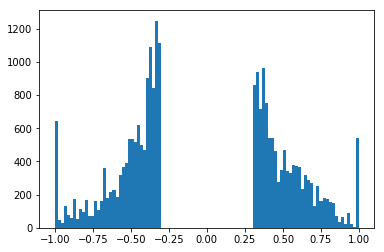

In [56]:
print(len(y_gen))
pyplot.hist(y_gen, bins=100)
plt.show()

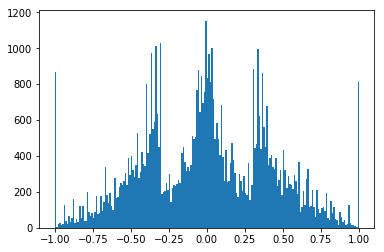

In [57]:
pyplot.hist(np.concatenate((y_gen, y_data_nz, y_data_z)), bins=200)
plt.show()

In [61]:
X_data_nz = X_data_nz.reshape((*X_data_nz.shape, 1))
X_data_z = X_data_z.reshape((*X_data_z.shape, 1))
print(X_gen.shape)
print(X_data_nz.shape)
print(X_data_z.shape)

(24604, 160, 320, 1)
(10302, 160, 320, 1)
(25427, 160, 320, 1)


In [62]:
XG_data, YG_data = shuffle([np.concatenate((X_gen, X_data_nz, X_data_z)), np.concatenate((y_gen, y_data_nz, y_data_z))])

In [90]:
np.save('XG_data.npy', XG_train)
np.save('YG_data.npy', YG_train)

In [ ]:
XG_train = np.load('XG_data.npy')
YG_train = np.load('YG_data.npy')

In [64]:
XG_train, YG_train = (XG_data[:-5000], YG_data[:-5000])
XG_val, YG_val = (XG_data[-5000:], YG_data[-5000:])

-0.02830189
-22


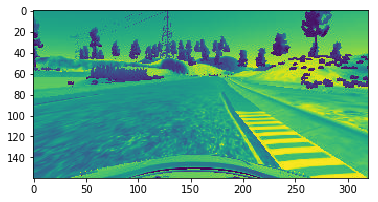

In [89]:

imshow(XG_train[pic_num,:,:,0])
print(YG_train[pic_num])
pic_num-=1
print(pic_num)

In [66]:
print(XG_train.shape)
print(YG_train.shape)

(55333, 160, 320, 1)
(55333,)


0.0754717


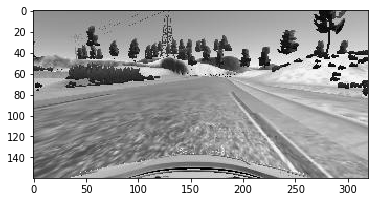

In [67]:
imshow(XG_train[-15][:,:,0], cmap='gray')
print(YG_train[-15])

In [91]:
print(np.min(YG_train))
print(np.max(YG_train))

-1.0
1.0


In [92]:
print('len(YG_train):', len(YG_train))
print(len([x for x in YG_train if x > 0]))
print(len([x for x in YG_train if x < 0]))
print('x==0:',len([x for x in YG_train if x == 0.]))
print('x<0.2:', len([x for x in YG_train if abs(x) < 0.2 ]))

len(YG_train): 55333
26561
28772
x==0: 0
x<0.2: 16112


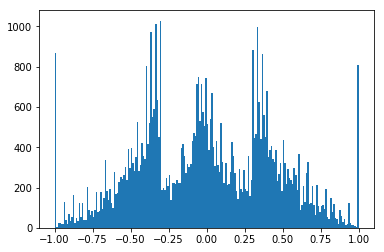

In [93]:
pyplot.hist(YG_train, bins=200)
plt.show()

In [94]:
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization

In [119]:
def build_model(X_input):
    winit = initializers.TruncatedNormal(stddev=5e-02)
    image_shape = X_input.shape[1:]
    print(X_input.shape)
    
    input_img = Input(shape=image_shape)
    # 80x160x3
    crop = Cropping2D(cropping=((50,30), (0,0)))(input_img)    
    # 40x160x3
    #norm = Lambda(lambda x: x/127.5 - 1.)(crop)
    norm = Lambda(lambda x: x/255 - 0.5)(crop)
    # 40x160x3
    
    conv = Conv2D(1, (1,1), padding='same', kernel_initializer=winit)(norm)
    # conv layer
    conv = Conv2D(32, (7,7), padding='same', strides=(1,2), kernel_initializer=winit)(norm)
    #conv = BatchNormalization()(conv)
    conv = Activation('elu')(conv)    
    conv = Dropout(0.7)(conv)
    conv = MaxPooling2D((1,2))(conv)
    # 20x80x32
    
    # conv layer
    conv = Conv2D(48, (5,5), padding='same', kernel_initializer=winit)(conv)
    #conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    #conv = Dropout(0.7)(conv)
    conv = MaxPooling2D((2,2))(conv)
    
    # conv layer
    conv = Conv2D(64, (3,3), padding='same')(conv)
    #conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Dropout(0.7)(conv)
    conv = MaxPooling2D((2,2))(conv)
    
    # conv layer
    conv = Conv2D(128, (3,3), padding='same')(conv)
    #conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = MaxPooling2D((2,2))(conv)
    
    conv = Conv2D(256, (3,3), padding='valid')(conv)
    #conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = MaxPooling2D((2,2))(conv)
    
    # 2x17x128
    #conv = Dropout(0.7)(conv5)
    flat = Flatten()(conv)
    dense1 = Dense(256, kernel_initializer=winit, activation='relu')(flat)
                
    dense2 = Dense(512, kernel_initializer=winit, activation='relu')(dense1)
    dense2 = Dense(1024, kernel_initializer=winit, activation='relu')(dense2)
    dense2 = Dropout(0.6)(dense2)
    #dense2 = Dense(256)(dense2)
    #dense2 = BatchNormalization()(dense2)
    
    output_layer = Dense(1)(dense2)
        
    model = Model(inputs=input_img, outputs=output_layer)
    return model

In [120]:
model = build_model(XG_train)
model.compile('adam', 'mse')

(55333, 160, 320, 1)


In [121]:
for lay in model.layers:
    print("{:<20}: {}".format(lay.name, lay.output_shape[1:]))

input_5             : (160, 320, 1)
cropping2d_5        : (80, 320, 1)
lambda_5            : (80, 320, 1)
conv2d_24           : (80, 160, 32)
activation_19       : (80, 160, 32)
dropout_13          : (80, 160, 32)
max_pooling2d_19    : (80, 80, 32)
conv2d_25           : (80, 80, 48)
activation_20       : (80, 80, 48)
max_pooling2d_20    : (40, 40, 48)
conv2d_26           : (40, 40, 64)
activation_21       : (40, 40, 64)
dropout_14          : (40, 40, 64)
max_pooling2d_21    : (20, 20, 64)
conv2d_27           : (20, 20, 128)
activation_22       : (20, 20, 128)
max_pooling2d_22    : (10, 10, 128)
conv2d_28           : (8, 8, 256)
activation_23       : (8, 8, 256)
max_pooling2d_23    : (4, 4, 256)
flatten_5           : (4096,)
dense_17            : (256,)
dense_18            : (512,)
dense_19            : (1024,)
dropout_15          : (1024,)
dense_20            : (1,)


In [122]:
history = model.fit(XG_train, YG_train, 
                    epochs=30, verbose=2, batch_size=256,
                    validation_data=(XG_val, YG_val),
                    callbacks=[
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=2),
                        ModelCheckpoint("model/ml_105.{epoch:02d}-{val_loss:.4f}.hdf5"),
                        #EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-03)
                    ])

Train on 55333 samples, validate on 5000 samples
Epoch 1/100
58s - loss: 0.1870 - val_loss: 0.0275
Epoch 2/100
57s - loss: 0.1673 - val_loss: 0.0129
Epoch 3/100
57s - loss: 0.1600 - val_loss: 0.0057
Epoch 4/100
57s - loss: 0.1554 - val_loss: 0.0128
Epoch 5/100
57s - loss: 0.1506 - val_loss: 0.0108
Epoch 6/100
58s - loss: 0.1472 - val_loss: 0.0148
Epoch 7/100
57s - loss: 0.1445 - val_loss: 0.0206
Epoch 8/100
57s - loss: 0.1423 - val_loss: 0.0155
Epoch 9/100

Epoch 00008: reducing learning rate to 0.0005000000237487257.
56s - loss: 0.1403 - val_loss: 0.0253
Epoch 10/100
57s - loss: 0.1362 - val_loss: 0.0156
Epoch 11/100
57s - loss: 0.1349 - val_loss: 0.0177
Epoch 12/100
58s - loss: 0.1341 - val_loss: 0.0217
Epoch 13/100
57s - loss: 0.1336 - val_loss: 0.0198
Epoch 14/100

Epoch 00013: reducing learning rate to 0.0002500000118743628.
58s - loss: 0.1331 - val_loss: 0.0128
Epoch 15/100
57s - loss: 0.1313 - val_loss: 0.0235
Epoch 16/100
57s - loss: 0.1308 - val_loss: 0.0187
Epoch 17/100
57s -

In [123]:
model.save('model_105.h5')

In [124]:
# check prediction
pred = model.predict(XG_train[1000:1050])
for p,y in zip(pred, YG_train[1000:1050]):
    print (p,y)

[ 0.57562798] 0.6090226
[-0.54123098] -0.9150943
[ 0.48891285] 0.8207547
[-0.00832501] 0.7075471
[ 0.48966888] 0.4905661
[-0.08970312] -0.3207547
[ 0.10289878] -0.3458647
[-0.11488464] -0.3584906
[-0.06322439] -0.3867925
[ 0.04924977] 0.5263158
[-0.52028131] -0.6320755
[-0.06899164] -0.4661654
[ 0.37924305] 0.3773585
[-0.12402716] 0.3609022
[-0.07681603] 0.3207547
[-0.27096254] 0.4964977
[-0.28279495] -0.3909774
[-0.05332987] 0.5
[ 0.03822757] 0.5943396
[-0.45409748] -0.5943396
[ 0.19057642] 0.3007519
[ 0.48593983] 0.5471698
[-0.0931099] 0.5566038
[-0.21725303] -0.3207547
[-0.13048472] -0.7819549
[-0.44223231] -0.3207547
[-0.44901207] -0.3584906
[ 0.00687499] -0.481203
[ 0.05813895] 0.6015037
[-0.01344241] -0.5
[ 0.47946414] 0.6792453
[ 0.25138092] 0.3458647
[-0.43618989] -0.3157895
[-0.26759407] -0.406015
[-0.30542007] -0.3113208
[-0.20912808] -0.5639098
[-0.37080869] -0.3396226
[ 0.00125967] 0.7518798
[ 0.0348565] -0.3679245
[ 0.03449066] -0.3308271
[-0.08012219] -0.4622642
[-0.08143

In [105]:
from keras.models import load_model

In [106]:
model = load_model('model_normal.h5')

/home/viacheslav/.local/lib/python3.5/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
print(y_data[0:10])
print(*model.predict(X_data[0:11], batch_size=1)*1.2)

In [102]:
from keras import backend as K

In [103]:
K.clear_session()

In [ ]:
output_layer_num = 5
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[output_layer_num].output])
print(model.layers[output_layer_num].name)

layer_output = get_3rd_layer_output([XG_train[-10:-2], 0])[0]

In [ ]:
imshow(XG_train[-10,:,:,0])

In [ ]:
img = layer_output[0]
print(np.max(img))
print(img.shape)
img = (img + 1.0)*127.5
print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#imshow(img.astype(np.ubyte))

In [ ]:
# function to display images
def display(images, titles=['']):
    fig, axes = subplots(images.shape[2]//4, 4, figsize=(16,32),
                             subplot_kw={'xticks': [], 'yticks': []})

    #fig.subplots_adjust(hspace=0.3, wspace=0.1)
    for i, (ax, layer) in enumerate(zip(axes.flat, range(images.shape[2]))):
        ax.imshow(images[:,:,layer], cmap='gray', interpolation="nearest")

In [ ]:
display(layer_output[0])

In [ ]:
np.max((layer_output[0]+1)*127.5)

In [ ]:
layer_output.shape